<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 8.5: Text Classification

In this lab you will implement different types of feature engineering for text classification:
* Count vectors
* TF-IDF vectors (word level, n-gram level, character level)
* Text/NLP based features
* Topic models
  
The following classification algorithms will be applied to the count and TF-IDF vector features:
* Naïve Bayes
* Logistic Regression
* Support Vector Machine
* Random Forest
* Gradient Boosting

## Import libraries

In [5]:
## Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import spacy

from collections import Counter

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# import warnings
# warnings.filterwarnings('ignore')

## Load data

Sample:

    __label__2 Stuning even for the non-gamer: This sound ...
    __label__2 The best soundtrack ever to anything.: I'm ...
    __label__2 Amazing!: This soundtrack is my favorite m ...
    __label__2 Excellent Soundtrack: I truly like this so ...
    __label__2 Remember, Pull Your Jaw Off The Floor Afte ...
    __label__2 an absolute masterpiece: I am quite sure a ...
    __label__1 Buyer beware: This is a self-published boo ...
    . . .
    
There are only two **labels**:
- `__label__1`
- `__label__2`

In [6]:
## Loading the data

df_corpus = pd.read_fwf(
    filepath_or_buffer = r'C:\Users\Vinitha\Desktop\IOD\DATA\corpus.txt',
    colspecs = [(9, 10),   # label: get only the numbers 1 or 2
                (11, 9000) # text: makes the it big enough to get to the end of the line
               ],
    header = 0,
    names = ['label', 'text'],
    lineterminator = '\n'
)

# convert label from [1, 2] to [0, 1]
df_corpus['label'] = df_corpus['label'] - 1

## Inspect the data

In [7]:
# ANSWER
# Head
df_corpus.head()

,label,text
0,1,The best soundtrack ever to anything.: I'm rea...
1,1,Amazing!: This soundtrack is my favorite music...
2,1,Excellent Soundtrack: I truly like this soundt...
3,1,"Remember, Pull Your Jaw Off The Floor After He..."
4,1,an absolute masterpiece: I am quite sure any o...


In [8]:
df_corpus.shape

(9999, 2)

In [9]:
# Tail
df_corpus.info

<bound method DataFrame.info of       label                                               text
0         1  The best soundtrack ever to anything.: I'm rea...
1         1  Amazing!: This soundtrack is my favorite music...
2         1  Excellent Soundtrack: I truly like this soundt...
3         1  Remember, Pull Your Jaw Off The Floor After He...
4         1  an absolute masterpiece: I am quite sure any o...
...     ...                                                ...
9994      1  A revelation of life in small town America in ...
9995      1  Great biography of a very interesting journali...
9996      0  Interesting Subject; Poor Presentation: You'd ...
9997      0  Don't buy: The box looked used and it is obvio...
9998      1  Beautiful Pen and Fast Delivery.: The pen was ...

[9999 rows x 2 columns]>

In [10]:
# Type
df_corpus.dtypes

label     int64
text     object
dtype: object

In [11]:
df_corpus['text_length'] = df_corpus['text'].apply(len)
df_corpus['text_length'].describe()

count    9999.000000
mean      438.703870
std       239.255565
min       101.000000
25%       238.000000
50%       391.000000
75%       605.000000
max      1015.000000
Name: text_length, dtype: float64

In [12]:
# Describe
df_corpus.describe(include='all')

,label,text,text_length
count,9999.000000,9999,9999.000000
unique,NaN,9999,NaN
top,NaN,The best soundtrack ever to anything.: I'm rea...,NaN
freq,NaN,1,NaN
mean,0.490249,NaN,438.703870
std,0.499930,NaN,239.255565
min,0.000000,NaN,101.000000
25%,0.000000,NaN,238.000000
50%,0.000000,NaN,391.000000
75%,1.000000,NaN,605.000000


In [13]:
# Null values
df_corpus.isnull().sum()

label          0
text           0
text_length    0
dtype: int64

In [14]:
# Label value count
df_corpus['label'].value_counts()

label
0    5097
1    4902
Name: count, dtype: int64

In [15]:
# Text sample
df_corpus['text'].sample(5)

788     "Hallelujah!" is what I said when I finished t...
3011    potty mouth: great movie, but too much swerain...
3392    Customer service: The item is excellent and th...
7904    Asolutely fantastic: "Lola rennt" is definatel...
5903    It arrived. It charged. Camera works.: Somewhe...
Name: text, dtype: object

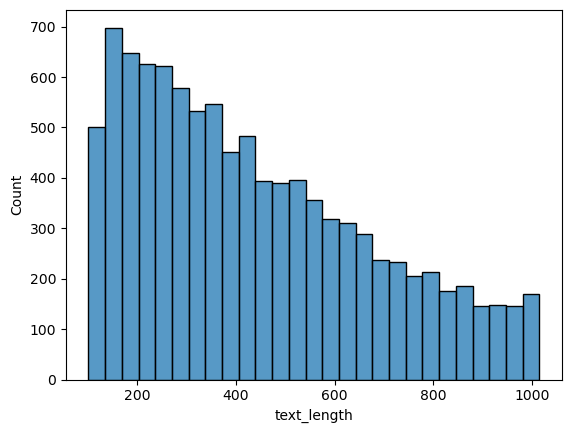

In [16]:
# Distribution of text length
df_corpus['text_length'] = df_corpus['text'].apply(len)
sns.histplot(df_corpus['text_length'])
plt.show()

## Split the data into train and test

In [17]:
## ANSWER
## split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_corpus['text'], df_corpus['label'], test_size=0.2, random_state=42)

## Feature Engineering

### Count Vectors as features

In [18]:
# create a count vectorizer object
count_vect = CountVectorizer(token_pattern = r'\w{1,}')

# Learn a vocabulary dictionary of all tokens in the raw documents
count_vect.fit(X_train)

# Transform documents to document-term matrix.
X_train_count = count_vect.transform(X_train)
X_test_count = count_vect.transform(X_test)

In [19]:
X_train_count.shape

(7999, 28212)

### TF-IDF Vectors as features
- Word level
- N-Gram level
- Character level

In [20]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 5000)
print(tfidf_vect)

tfidf_vect.fit(X_train)
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf  = tfidf_vect.transform(X_test)

TfidfVectorizer(max_features=5000, token_pattern='\\w{1,}')
CPU times: total: 578 ms
Wall time: 2.38 s


In [21]:
X_train_tfidf.shape

(7999, 5000)

In [22]:
X_train_tfidf[2]

<1x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 83 stored elements in Compressed Sparse Row format>

In [23]:
%%time
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word',
                                   token_pattern = r'\w{1,}',
                                   ngram_range = (2, 3),
                                   max_features = 5000)
print(tfidf_vect_ngram)

tfidf_vect_ngram.fit(X_train)
X_train_tfidf_ngram = tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram  = tfidf_vect_ngram.transform(X_test)

TfidfVectorizer(max_features=5000, ngram_range=(2, 3), token_pattern='\\w{1,}')
CPU times: total: 3.05 s
Wall time: 11.8 s


In [24]:
X_train_tfidf_ngram.shape

(7999, 5000)

In [25]:
X_train_tfidf_ngram[4]

<1x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 84 stored elements in Compressed Sparse Row format>

In [26]:
%%time
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer = 'char',
                                         ngram_range = (2, 3),
                                         max_features = 5000)
print(tfidf_vect_ngram_chars)

tfidf_vect_ngram_chars.fit(X_train)
X_train_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(X_train)
X_test_tfidf_ngram_chars  = tfidf_vect_ngram_chars.transform(X_test)

TfidfVectorizer(analyzer='char', max_features=5000, ngram_range=(2, 3))
CPU times: total: 7.42 s
Wall time: 15.9 s


### Text / NLP based features

Create some other features.

char_count = Number of Characters in Text

word_count = Number of Words in Text

word_density = Average Number of Char in Words

punctuation_count = Number of Punctuation in Text

title_word_count = Number of Words in Title

uppercase_word_count = Number of Upperwords in Text


In [27]:
# Define functions to compute features
def char_count(text):
    return len(text)

def word_count(text):
    return len(text.split())

def word_density(text):
    words = text.split()
    if len(words) == 0:
        return 0
    return sum(len(word) for word in words) / len(words)

def punctuation_count(text):
    return sum(1 for char in text if char in string.punctuation)

def title_word_count(text):
    return sum(1 for word in text.split() if word.istitle())

def uppercase_word_count(text):
    return sum(1 for word in text.split() if word.isupper())

# Compute features for each text
def compute_features(df):
    df['char_count'] = df['text'].apply(char_count)
    df['word_count'] = df['text'].apply(word_count)
    df['word_density'] = df['text'].apply(word_density)
    df['punctuation_count'] = df['text'].apply(punctuation_count)
    df['title_word_count'] = df['text'].apply(title_word_count)
    df['uppercase_word_count'] = df['text'].apply(uppercase_word_count)
    return df


# Compute features
df_corpus = compute_features(df_corpus)

# Display the updated DataFrame
print(df_corpus.head())

# Optional: Measure computation time
import time
start_time = time.time()

# Compute features
df_corpus = compute_features(df_corpus)

print("Time taken to compute features: %s seconds" % (time.time() - start_time))


   label                                               text  text_length  \
0      1  The best soundtrack ever to anything.: I'm rea...          509   
1      1  Amazing!: This soundtrack is my favorite music...          760   
2      1  Excellent Soundtrack: I truly like this soundt...          743   
3      1  Remember, Pull Your Jaw Off The Floor After He...          481   
4      1  an absolute masterpiece: I am quite sure any o...          825   

   char_count  word_count  word_density  punctuation_count  title_word_count  \
0         509          97      4.257732                 14                 7   
1         760         129      4.899225                 40                24   
2         743         118      5.305085                 33                52   
3         481          87      4.540230                 22                30   
4         825         142      4.816901                 35                14   

   uppercase_word_count  
0                     3  
1         

In [28]:
# Define functions to compute features
def char_count(text):
    return len(text)

def word_count(text):
    return len(text.split())

def word_density(text):
    words = text.split()
    if len(words) == 0:
        return 0
    return sum(len(word) for word in words) / len(words)

def punctuation_count(text):
    return sum(1 for char in text if char in string.punctuation)

def title_word_count(text):
    return sum(1 for word in text.split() if word.istitle())

def uppercase_word_count(text):
    return sum(1 for word in text.split() if word.isupper())

# Compute features for each text
def compute_features(df):
    df['char_count'] = df['text'].apply(char_count)
    df['word_count'] = df['text'].apply(word_count)
    df['word_density'] = df['text'].apply(word_density)
    df['punctuation_count'] = df['text'].apply(punctuation_count)
    df['title_word_count'] = df['text'].apply(title_word_count)
    df['uppercase_word_count'] = df['text'].apply(uppercase_word_count)
    return df

# Compute features
df_corpus = compute_features(df_corpus)

# Display the updated DataFrame
print(df_corpus.head())

# Optional: Measure computation time
import time
start_time = time.time()

# Compute features
df_corpus = compute_features(df_corpus)

print("Time taken to compute features: %s seconds" % (time.time() - start_time))


   label                                               text  text_length  \
0      1  The best soundtrack ever to anything.: I'm rea...          509   
1      1  Amazing!: This soundtrack is my favorite music...          760   
2      1  Excellent Soundtrack: I truly like this soundt...          743   
3      1  Remember, Pull Your Jaw Off The Floor After He...          481   
4      1  an absolute masterpiece: I am quite sure any o...          825   

   char_count  word_count  word_density  punctuation_count  title_word_count  \
0         509          97      4.257732                 14                 7   
1         760         129      4.899225                 40                24   
2         743         118      5.305085                 33                52   
3         481          87      4.540230                 22                30   
4         825         142      4.816901                 35                14   

   uppercase_word_count  
0                     3  
1         

In [29]:
## load spaCy
nlp = spacy.load('en_core_web_sm')

Part of Speech in **SpaCy**

    POS   DESCRIPTION               EXAMPLES
    ----- ------------------------- ---------------------------------------------
    ADJ   adjective                 big, old, green, incomprehensible, first
    ADP   adposition                in, to, during
    ADV   adverb                    very, tomorrow, down, where, there
    AUX   auxiliary                 is, has (done), will (do), should (do)
    CONJ  conjunction               and, or, but
    CCONJ coordinating conjunction  and, or, but
    DET   determiner                a, an, the
    INTJ  interjection              psst, ouch, bravo, hello
    NOUN  noun                      girl, cat, tree, air, beauty
    NUM   numeral                   1, 2017, one, seventy-seven, IV, MMXIV
    PART  particle                  's, not,
    PRON  pronoun                   I, you, he, she, myself, themselves, somebody
    PROPN proper noun               Mary, John, London, NATO, HBO
    PUNCT punctuation               ., (, ), ?
    SCONJ subordinating conjunction if, while, that
    SYM   symbol                    $, %, §, ©, +, −, ×, ÷, =, :), 😝
    VERB  verb                      run, runs, running, eat, ate, eating
    X     other                     sfpksdpsxmsa
    SPACE space
    
Find out number of Adjective, Adverb, Noun, Numeric, Pronoun, Proposition, Verb.

    Hint:
    1. Convert text to spacy document
    2. Use pos_
    3. Use Counter

In [30]:
# Initialise some columns for feature's counts
df_corpus['adj_count'] = 0
df_corpus['adv_count'] = 0
df_corpus['noun_count'] = 0
df_corpus['num_count'] = 0
df_corpus['pron_count'] = 0
df_corpus['propn_count'] = 0
df_corpus['verb_count'] = 0

In [31]:
# Function to count specific parts of speech
def count_pos(text):
    # Convert text to a spaCy document
    doc = nlp(text)
    
    # Initialize a Counter to count occurrences of POS tags
    pos_counts = Counter(token.pos_ for token in doc)

    # Return counts for specific parts of speech, defaulting to 0 if not found
    return {
        'adj_count': pos_counts.get('ADJ', 0),
        'adv_count': pos_counts.get('ADV', 0),
        'noun_count': pos_counts.get('NOUN', 0),
        'num_count': pos_counts.get('NUM', 0),
        'pron_count': pos_counts.get('PRON', 0),
        'propn_count': pos_counts.get('PROPN', 0),
        'verb_count': pos_counts.get('VERB', 0)
    }

# Assuming df_corpus is your DataFrame and has a 'text' column
# Apply the function to each row in the DataFrame
pos_counts_df = df_corpus['text'].apply(lambda text: pd.Series(count_pos(text)))

# Concatenate the new counts with the original DataFrame
df_corpus = pd.concat([df_corpus, pos_counts_df], axis=1)

# Inspect the updated DataFrame with new features
print(df_corpus.head())

   label                                               text  text_length  \
0      1  The best soundtrack ever to anything.: I'm rea...          509   
1      1  Amazing!: This soundtrack is my favorite music...          760   
2      1  Excellent Soundtrack: I truly like this soundt...          743   
3      1  Remember, Pull Your Jaw Off The Floor After He...          481   
4      1  an absolute masterpiece: I am quite sure any o...          825   

   char_count  word_count  word_density  punctuation_count  title_word_count  \
0         509          97      4.257732                 14                 7   
1         760         129      4.899225                 40                24   
2         743         118      5.305085                 33                52   
3         481          87      4.540230                 22                30   
4         825         142      4.816901                 35                14   

   uppercase_word_count  adj_count  ...  pron_count  propn_cou

In [33]:
#Function to count specific parts of speech
def count_pos(text):
    # Convert text to a spacy document
    doc = nlp (text)
    
    # Initialize a Counter to count occurrences of POS tags
    pos_counts = Counter( [token.pos_ for token in doc])

    # Return counts for specific parts of speech, defaulting to 0 if not found
    return {
        'adj_count': pos_counts.get('ADJ', 0),
        'adv_count': pos_counts.get('ADV', 0),
        'noun_count': pos_counts.get('NOUN', 0),
        'num_count': pos_counts.get('NUM', 0),
        'pron_count': pos_counts.get('PRON', 0),
        'propn_count': pos_counts.get('PROPN', 0),
        'verb_count': pos_counts.get('VERB', 0)
         }
# Apply the function to each row in the DataFrame

    df_corpus ['text'].apply(lambda text: pd.Series (count_pos (text)))
# Inspect the updated DataFrame with new features
print(df_corpus.head())

   label                                               text  text_length  \
0      1  The best soundtrack ever to anything.: I'm rea...          509   
1      1  Amazing!: This soundtrack is my favorite music...          760   
2      1  Excellent Soundtrack: I truly like this soundt...          743   
3      1  Remember, Pull Your Jaw Off The Floor After He...          481   
4      1  an absolute masterpiece: I am quite sure any o...          825   

   char_count  word_count  word_density  punctuation_count  title_word_count  \
0         509          97      4.257732                 14                 7   
1         760         129      4.899225                 40                24   
2         743         118      5.305085                 33                52   
3         481          87      4.540230                 22                30   
4         825         142      4.816901                 35                14   

   uppercase_word_count  adj_count  ...  pron_count  propn_cou

In [39]:
df_corpus.columns

Index(['label', 'text', 'text_length', 'char_count', 'word_count',
       'word_density', 'punctuation_count', 'title_word_count',
       'uppercase_word_count', 'adj_count', 'adv_count', 'noun_count',
       'num_count', 'pron_count', 'propn_count', 'verb_count', 'adj_count',
       'adv_count', 'noun_count', 'num_count', 'pron_count', 'propn_count',
       'verb_count'],
      dtype='object')

In [37]:
cols = [
    'char_count', 'word_count', 'word_density',
    'punctuation_count', 'title_word_count',
    'uppercase_word_count',
    'adj_count','adv_count', 'noun_count', 'num_count',
    'pron_count', 'propn_count', 'verb_count']

df_corpus[cols].sample(5)

,char_count,word_count,word_density,punctuation_count,title_word_count,uppercase_word_count,adj_count,adj_count,adv_count,adv_count,noun_count,noun_count,num_count,num_count,pron_count,pron_count,propn_count,propn_count,verb_count,verb_count
185,123,25,3.960000,1,1,0,0,4,0,1,0,4,0,0,0,2,0,0,0,5
8269,186,39,3.794872,4,6,1,0,4,0,1,0,7,0,0,0,4,0,2,0,3
4175,139,27,4.185185,7,4,2,0,2,0,1,0,5,0,0,0,5,0,0,0,4
6589,883,148,4.972973,49,21,2,0,16,0,10,0,26,0,4,0,9,0,14,0,17
9765,313,48,5.541667,16,10,0,0,7,0,2,0,6,0,1,0,8,0,6,0,4


In [38]:
df_corpus.shape

(9999, 23)

### Topic Models as features

In [40]:
%%time
# train a LDA Model
lda_model = LatentDirichletAllocation(n_components = 20, learning_method = 'online', max_iter = 20)

X_topics = lda_model.fit_transform(X_train_count)
topic_word = lda_model.components_
vocab = count_vect.get_feature_names_out()

CPU times: total: 59.9 s
Wall time: 1min 49s


In [41]:
# view the topic models
n_top_words = 10
topic_summaries = []
print('Group Top Words')
print('-----', '-'*80)
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    top_words = ' '.join(topic_words)
    topic_summaries.append(top_words)
    print('  %3d %s' % (i, top_words))

Group Top Words
----- --------------------------------------------------------------------------------
    0 apple products g4 powerbook ibook macally ac foreign tends stewart
    1 cave bear clan freud rods paragraph horse tree riding 2006
    2 camera card battery canon cute u device camcorder digital memory
    3 index anderson lincoln boat bbc anthology professionals condescending scent theatrical
    4 the book of and a is to in this read
    5 practice theory magazine stands news los et ignorant dell principles
    6 skin hp japanese eye sell errors w color moment musiq
    7 cd music album of is s songs song are sound
    8 grammar everest replacing explaining popping painted element glory vintage roman
    9 la de provide info y en que el harry bra
   10 mad hip diary taught ain mel richard acts sounding san
   11 recent higgins gay pushed crawford flea extension hide noir dedicated
   12 max cat 00 asleep dollars daily generation salt war challenging
   13 pratchett rip j reme

## Modelling

Run the following cells to train a number of models on the count vector and TF-IDF vector feature sets generated above.

In [42]:
## helper function

def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)

    return accuracy_score(predictions, y_test)

In [43]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Count Vectors',
                                  'WordLevel TF-IDF',
                                  'N-Gram Vectors',
                                  'CharLevel Vectors'])

### Naive Bayes Classifier

In [44]:
%%time
# Naive Bayes on Count Vectors
accuracy1 = train_model(MultinomialNB(), X_train_count, y_train, X_test_count)
print('NB, Count Vectors    : %.4f\n' % accuracy1)

NB, Count Vectors    : 0.8520

CPU times: total: 0 ns
Wall time: 13 ms


In [45]:
%%time
# Naive Bayes on Word Level TF IDF Vectors
accuracy2 = train_model(MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf)
print('NB, WordLevel TF-IDF : %.4f\n' % accuracy2)

NB, WordLevel TF-IDF : 0.8550

CPU times: total: 15.6 ms
Wall time: 13 ms


In [46]:
%%time
# Naive Bayes on Ngram Level TF IDF Vectors
accuracy3 = train_model(MultinomialNB(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('NB, N-Gram Vectors   : %.4f\n' % accuracy3)

NB, N-Gram Vectors   : 0.8360

CPU times: total: 0 ns
Wall time: 11 ms


In [47]:
%%time
# # Naive Bayes on Character Level TF IDF Vectors
accuracy4 = train_model(MultinomialNB(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('NB, CharLevel Vectors: %.4f\n' % accuracy4)

NB, CharLevel Vectors: 0.8195

CPU times: total: 31.2 ms
Wall time: 58 ms


In [48]:
results.loc['Naïve Bayes'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

### Linear Classifier

In [49]:
%%time
# Linear Classifier on Count Vectors
accuracy1 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 350), X_train_count, y_train, X_test_count)
print('LR, Count Vectors    : %.4f\n' % accuracy1)

LR, Count Vectors    : 0.8520

CPU times: total: 3min 6s
Wall time: 34.1 s


In [50]:
%%time
# Linear Classifier on Word Level TF IDF Vectors
accuracy2 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 100), X_train_tfidf, y_train, X_test_tfidf)
print('LR, WordLevel TF-IDF : %.4f\n' % accuracy2)

LR, WordLevel TF-IDF : 0.8715

CPU times: total: 0 ns
Wall time: 50.8 ms


In [51]:
%%time
# Linear Classifier on Ngram Level TF IDF Vectors
accuracy3 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 100), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('LR, N-Gram Vectors   : %.4f\n' % accuracy3)

LR, N-Gram Vectors   : 0.8295

CPU times: total: 0 ns
Wall time: 54.3 ms


In [52]:
%%time
# Linear Classifier on Character Level TF IDF Vectors
accuracy4 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 100), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('LR, CharLevel Vectors: %.4f\n' % accuracy4)

LR, CharLevel Vectors: 0.8490

CPU times: total: 78.1 ms
Wall time: 311 ms


In [53]:
results.loc['Logistic Regression'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

### Support Vector Machine

In [54]:
%%time
# Support Vector Machine on Count Vectors
accuracy1 = train_model(LinearSVC(), X_train_count, y_train, X_test_count)
print('SVM, Count Vectors    : %.4f\n' % accuracy1)

SVM, Count Vectors    : 0.8345

CPU times: total: 688 ms
Wall time: 831 ms


In [55]:
%%time
# Support Vector Machine on Word Level TF IDF Vectors
accuracy2 = train_model(LinearSVC(), X_train_tfidf, y_train, X_test_tfidf)
print('SVM, WordLevel TF-IDF : %.4f\n' % accuracy2)

SVM, WordLevel TF-IDF : 0.8605

CPU times: total: 46.9 ms
Wall time: 132 ms


In [56]:
%%time
# Support Vector Machine on Ngram Level TF IDF Vectors
accuracy3 = train_model(LinearSVC(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('SVM, N-Gram Vectors   : %.4f\n' % accuracy3)

SVM, N-Gram Vectors   : 0.8120

CPU times: total: 62.5 ms
Wall time: 105 ms


In [57]:
%%time
# Support Vector Machine on Character Level TF IDF Vectors
accuracy4 = train_model(LinearSVC(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('SVM, CharLevel Vectors: %.4f\n' % accuracy4)

SVM, CharLevel Vectors: 0.8590

CPU times: total: 766 ms
Wall time: 1.28 s


In [58]:
results.loc['Support Vector Machine'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

### Bagging Models

In [59]:
%%time
# Bagging (Random Forest) on Count Vectors
accuracy1 = train_model(RandomForestClassifier(n_estimators = 100), X_train_count, y_train, X_test_count)
print('RF, Count Vectors    : %.4f\n' % accuracy1)

RF, Count Vectors    : 0.8155

CPU times: total: 8.67 s
Wall time: 20.4 s


In [60]:
%%time
# Bagging (Random Forest) on Word Level TF IDF Vectors
accuracy2 = train_model(RandomForestClassifier(n_estimators = 100), X_train_tfidf, y_train, X_test_tfidf)
print('RF, WordLevel TF-IDF : %.4f\n' % accuracy2)

RF, WordLevel TF-IDF : 0.8320

CPU times: total: 6.94 s
Wall time: 10.9 s


In [61]:
%%time
# Bagging (Random Forest) on Ngram Level TF IDF Vectors
accuracy3 = train_model(RandomForestClassifier(n_estimators = 100), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('RF, N-Gram Vectors   : %.4f\n' % accuracy3)

RF, N-Gram Vectors   : 0.7815

CPU times: total: 5.61 s
Wall time: 13.2 s


In [62]:
%%time
# Bagging (Random Forest) on Character Level TF IDF Vectors
accuracy4 = train_model(RandomForestClassifier(n_estimators = 100), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('RF, CharLevel Vectors: %.4f\n' % accuracy4)

RF, CharLevel Vectors: 0.7725

CPU times: total: 22.5 s
Wall time: 37.4 s


In [63]:
results.loc['Random Forest'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

### Boosting Models

In [64]:
%%time
# Gradient Boosting on Count Vectors
accuracy1 = train_model(GradientBoostingClassifier(), X_train_count, y_train, X_test_count)
print('GB, Count Vectors    : %.4f\n' % accuracy1)

GB, Count Vectors    : 0.7990

CPU times: total: 6.14 s
Wall time: 13 s


In [65]:
%%time
# Gradient Boosting on Word Level TF IDF Vectors
accuracy2 = train_model(GradientBoostingClassifier(), X_train_tfidf, y_train, X_test_tfidf)
print('GB, WordLevel TF-IDF : %.4f\n' % accuracy2)

GB, WordLevel TF-IDF : 0.7920

CPU times: total: 16.6 s
Wall time: 26.3 s


In [66]:
%%time
# Gradient Boosting on Ngram Level TF IDF Vectors
accuracy3 = train_model(GradientBoostingClassifier(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('GB, N-Gram Vectors   : %.4f\n' % accuracy3)

GB, N-Gram Vectors   : 0.7400

CPU times: total: 7.92 s
Wall time: 16.5 s


In [67]:
%%time
# Gradient Boosting on Character Level TF IDF Vectors
accuracy4 = train_model(GradientBoostingClassifier(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('GB, CharLevel Vectors: %.4f\n' % accuracy4)

GB, CharLevel Vectors: 0.8020

CPU times: total: 2min 19s
Wall time: 3min 35s


In [68]:
results.loc['Gradient Boosting'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [69]:
results

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors
Naïve Bayes,0.8520,0.8550,0.8360,0.8195
Logistic Regression,0.8520,0.8715,0.8295,0.8490
Support Vector Machine,0.8345,0.8605,0.8120,0.8590
Random Forest,0.8155,0.8320,0.7815,0.7725
Gradient Boosting,0.7990,0.7920,0.7400,0.8020


Which combination of features and model performed the best?



---



---



> > > > > > > > > © 2024 Institute of Data


---



---



